<a href="https://colab.research.google.com/github/dwh-xcs/repo-ciencia-dados-aprendizado-maquina/blob/main/001_Ci%C3%AAncia_de_Dados_e_Aprendizado_de_M%C3%A1quina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ciência de Dados e Aprendizado de Máquina

---

# Previsão de Resultados de Jogos do Campeonato Brasileiro (2006–2025)

**Autor:**

- Nome David Costa

# Resumo

Este notebook revisado implementa um pipeline reprodutível para classificação do resultado de partidas (Casa - H, Empate - D, Visitante - A) usando o dataset *jogos_brasileirao_af*. Contém EDA, engenharia de features, validação cruzada com *GridSearchCV* em pelo menos dois algoritmos (KNN e DecisionTree), comparação por métricas (Acurácia, Precisão, Recall, F1) e discussão dos resultados. O notebook foi preparado para rodar no Google Colab.

# Introdução
O Campeonato Brasileiro é uma das ligas de futebol mais competitivas e acompanhadas do mundo. Prever o resultado de uma partida é um desafio notório, influenciado por uma vasta gama de variáveis que incluem a forma atual das equipes, o mando de campo, táticas, desfalques e até mesmo fatores imprevisíveis.

Com o avanço da ciência de dados e do aprendizado de máquina, tornou-se possível analisar grandes volumes de dados históricos para identificar padrões que possam auxiliar na previsão desses resultados. Modelos de classificação podem ser treinados com informações de jogos passados para tentar determinar a probabilidade de uma vitória do time da casa, um empate ou uma vitória do time visitante.

Este projeto explora essa abordagem, utilizando um conjunto de dados históricos do Campeonato Brasileiro para desenvolver e avaliar modelos de aprendizado de máquina, seguindo um pipeline reprodutível que vai desde o tratamento dos dados até a avaliação final dos modelos.

# Objetivo
O objetivo principal deste projeto é desenvolver, aplicar e avaliar modelos de classificação de aprendizado de máquina para prever o resultado de partidas do Campeonato Brasileiro (Vitória da Casa - 'H', Empate - 'D', ou Vitória do Visitante - 'A').

Utilizando o conjunto de dados históricos de 2006 a 2023, o projeto focará em:

1. Aplicar e otimizar pelo menos dois algoritmos de classificação distintos: K-Nearest Neighbors (KNN) e Decision Tree (Árvore de Decisão).

2. Justificar a escolha das features (atributos) utilizadas para o treinamento, com foco em evitar o vazamento de dados (data leakage).

3. Comparar o desempenho dos modelos através de métricas de avaliação (Acurácia, Precisão, Recall e F1-Score) e confrontá-los com um modelo de baseline (baseado na classe majoritária) para avaliar a real contribuição dos modelos.

# 1. Importação de Bibliotecas

In [2]:

# Importações essenciais.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
from google.colab import auth
from google.colab import drive

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)


# 2. Pré-processamento dos Dados

In [3]:
# Autenticação do Google Drive.
auth.authenticate_user()
drive.mount('/content/drive', force_remount=True)

# Definição do Path.
sheet_path = '/content/drive/MyDrive/jogos_brasileirao_af.csv' # Atualize o path do seu drive.

# Lê o CSV com base no Path.
df = pd.read_csv(sheet_path)

# Verifica se foi criado uma celula vazia ou dataframe com os dados.
if df.empty:
  df = pd.read_csv('jogos_brasileirao_af.csv')

  if df.empty:
    print('DataFrame vazio !')

Mounted at /content/drive


In [4]:
# Exibe uma prévia dos dados.
print('\nDimensões do dataset:', df.shape)


Dimensões do dataset: (8406, 7)


In [5]:
display(df.head())

,round,stadium,home_team,home_score,away_score,away_team,year
0,1,Brinco de Ouro,Guarani,4.0,2.0,Vasco,2003
1,1,Ligga Arena,Athletico-PR,2.0,0.0,Grêmio,2003
2,1,Alfredo Jaconi,Juventude,2.0,2.0,São Paulo,2003
3,1,Mineirão,Cruzeiro,2.0,2.0,São Caetano,2003
4,1,Maracanã,Flamengo,1.0,1.0,Coritiba,2003


In [6]:
print('\nInformações do DataFrame:')
df.info()


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   round       8406 non-null   int64  
 1   stadium     8406 non-null   object 
 2   home_team   8406 non-null   object 
 3   home_score  8405 non-null   float64
 4   away_score  8405 non-null   float64
 5   away_team   8406 non-null   object 
 6   year        8406 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 459.8+ KB


In [7]:
# Coletas as colunas e seus datatypes.
datatypes = df.dtypes

print(datatypes)

round           int64
stadium        object
home_team      object
home_score    float64
away_score    float64
away_team      object
year            int64
dtype: object


In [8]:
# Faz um laço de repetição pela variavel coletando colunas e seus tipos.
for col, type in datatypes.items():
  # Verifica se o tipo da coluna é ponto flutuante.
  if type == 'float64':
    # Transforma as colunas em Inteiro.
    df[col] = df[col].fillna(0).astype('int64')
    print(f"Converted '{col}' to int64.")

Converted 'home_score' to int64.
Converted 'away_score' to int64.


## Cria a coluna de resultado da partida (H/D/A):
* H (Home): Vitória do time da casa (Gols Casa > Gols Visitante)
* D (Draw): Empate (Gols Casa == Gols Visitante)
* A (Away): Vitória do time visitante (Gols Casa < Gols Visitante)

In [9]:
# Criar coluna 'result' a partir dos placares.
df['result'] = df.apply(
    lambda row:
      'H' if row['home_score'] > row['away_score']
      else (
          'D' if row['home_score'] == row['away_score'] else 'A'
          ),
    axis=1)

print('\nDistribuição das classes (proporção):')
display(df['result'].value_counts(normalize=True).rename('proporcao').to_frame())

# Verificar nulos.
print('\nValores nulos por coluna:')
display(df.isnull().sum().to_frame('n_nulos'))


Distribuição das classes (proporção):


,proporcao
result,
H,0.497145
D,0.264097
A,0.238758



Valores nulos por coluna:


,n_nulos
round,0
stadium,0
home_team,0
home_score,0
away_score,0
away_team,0
year,0
result,0


## Aplicação de Filtros
* Filtrando o dataset para manter apenas as temporadas com 38 rodadas.

In [17]:
df = df[df['year'] > 2005]

# Análise Exploratória (EDA)

* Distribuição dos resultados
* Histogramas de gols
* Os 5 maiores campeões (por número de títulos)
* Evolução do número de títulos dos 5 maiores campeões (Pontuação Final)
* Top 5 clubes com melhor desempenho em casa (mandantes)
* Top 5 clubes com melhor desempenho fora de casa (visitantes)
* Análise da classificação da última temporada (Temporada 2024)


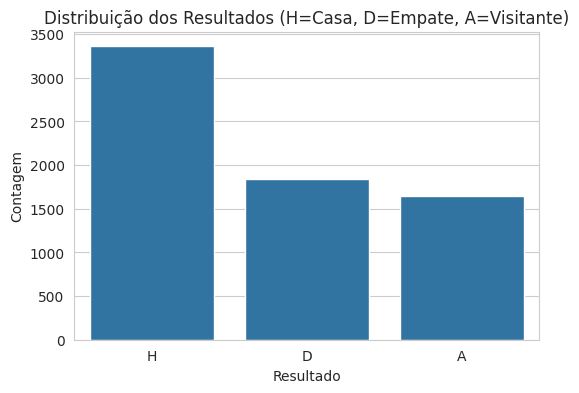

In [18]:
# Distribuição dos resultados
plt.figure(figsize=(6,4))
sns.countplot(x='result', data=df, order=['H','D','A'])
plt.title('Distribuição dos Resultados (H=Casa, D=Empate, A=Visitante)')
plt.xlabel('Resultado')
plt.ylabel('Contagem')
plt.show()

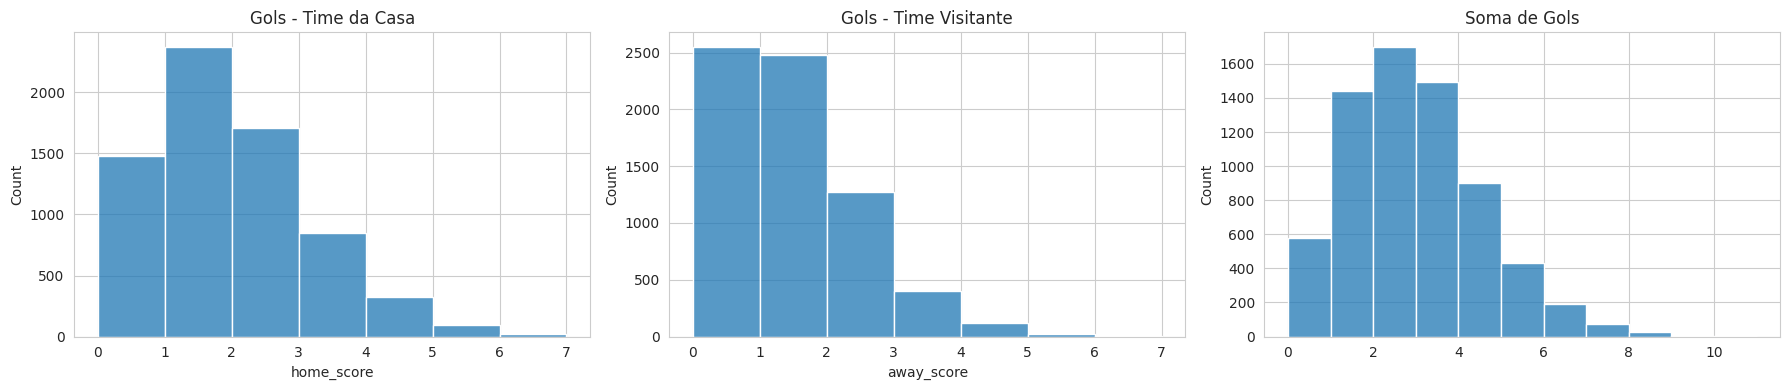

In [19]:

# Histogramas de gols.
fig, axes = plt.subplots(1,3,figsize=(18,4))
sns.histplot(df['home_score'], bins=range(0,8), ax=axes[0])
axes[0].set_title('Gols - Time da Casa')
sns.histplot(df['away_score'], bins=range(0,8), ax=axes[1])
axes[1].set_title('Gols - Time Visitante')
sns.histplot(df['soma'] if 'soma' in df.columns else (df['home_score'] + df['away_score']), bins=range(0,12), ax=axes[2])
axes[2].set_title('Soma de Gols')
plt.tight_layout()
plt.show()


In [20]:
# Preparação: Criar colunas de pontos para facilitar as análises.
def get_points(result):
    if result == 'H':
        return 3, 0  # Pontos Casa, Pontos Visitante.
    elif result == 'D':
        return 1, 1
    else: # result == 'A'.
        return 0, 3

# Aplicar a função para criar as novas colunas.
df[['points_home', 'points_away']] = df['result'].apply(lambda x: pd.Series(get_points(x)))

print("Colunas de pontos ('points_home', 'points_away') adicionadas.")
display(df[['year', 'home_team', 'away_team', 'result', 'points_home', 'points_away']].head())

Colunas de pontos ('points_home', 'points_away') adicionadas.


,year,home_team,away_team,result,points_home,points_away
1566,2006,Juventude,Paraná,H,3,0
1567,2006,Vasco,Internacional,D,1,1
1568,2006,Grêmio,Corinthians,H,3,0
1569,2006,São Paulo,Flamengo,H,3,0
1570,2006,São Caetano,Cruzeiro,H,3,0


Calculando campeões de 2006 a 2023...


/tmp/ipython-input-3980366353.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_champions.values, y=top_5_champions.index, orient='h', palette='viridis')


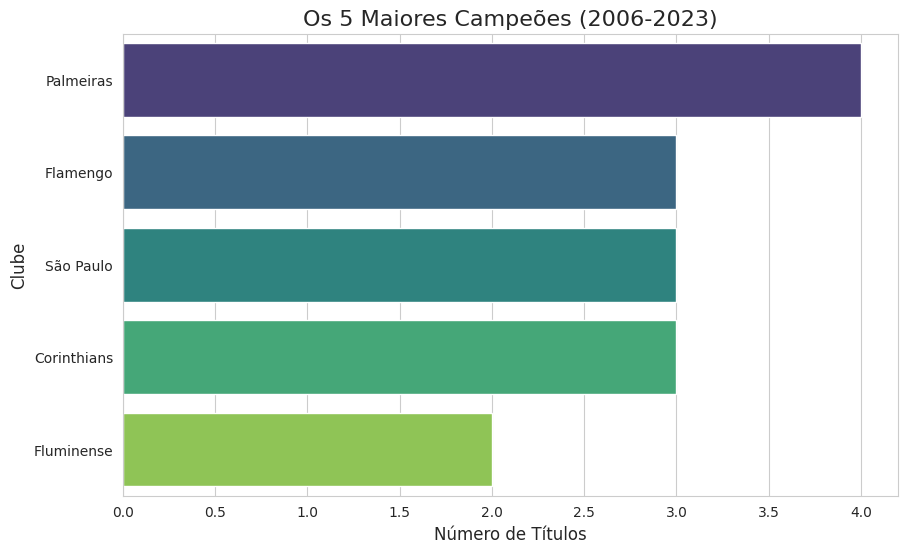

In [21]:
# Os 5 maiores campeões (por número de títulos).
print("Calculando campeões de 2006 a 2023...")

# 1. Calcular os pontos de casa de cada time por ano.
home_points = df.groupby(['year', 'home_team'])['points_home'].sum().reset_index().rename(columns={'home_team': 'team', 'points_home': 'P_home'})

# 2. Calcular os pontos de fora de cada time por ano.
away_points = df.groupby(['year', 'away_team'])['points_away'].sum().reset_index().rename(columns={'away_team': 'team', 'points_away': 'P_away'})

# 3. Juntar e somar os pontos.
total_points = pd.merge(home_points, away_points, on=['year', 'team'], how='outer').fillna(0)
total_points['total_pts'] = total_points['P_home'] + total_points['P_away']

# 4. Encontrar o campeão de cada ano (time com mais pontos).
# Usamos .loc[...idxmax()] para obter a linha inteira do time com max pontos.
champions = total_points.loc[total_points.groupby('year')['total_pts'].idxmax()]

# 5. Contar os títulos e pegar o Top 5.
top_5_champions = champions['team'].value_counts().head(5)

# 6. Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_champions.values, y=top_5_champions.index, orient='h', palette='viridis')
plt.title('Os 5 Maiores Campeões (2006-2023)', fontsize=16)
plt.xlabel('Número de Títulos', fontsize=12)
plt.ylabel('Clube', fontsize=12)
plt.show()

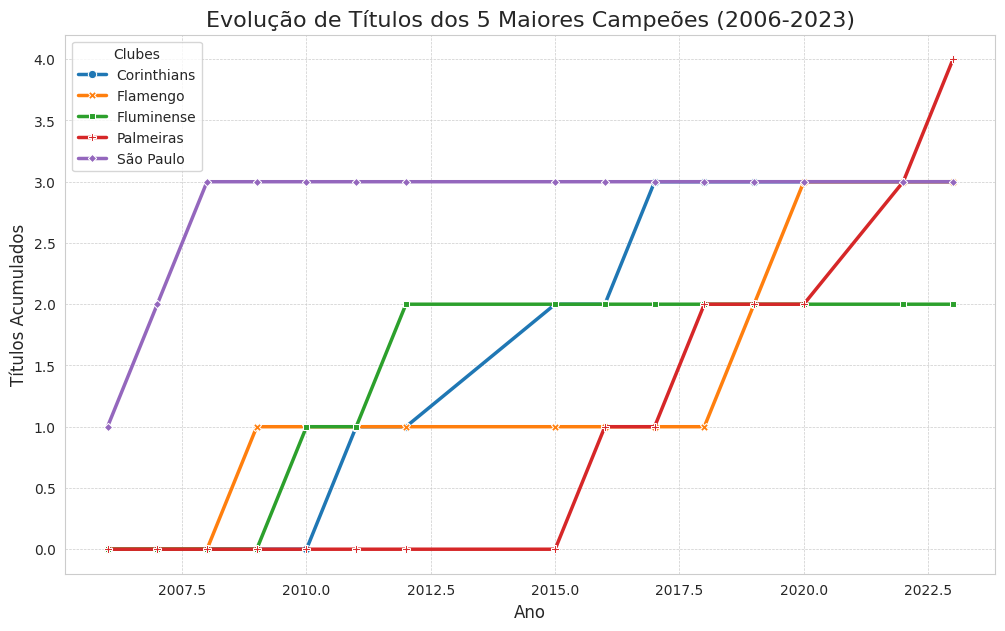

In [22]:
# Evolução do número de títulos dos 5 maiores campeões (Pontuação Final).
# Pegar a lista dos 5 maiores campeões.
top_5_teams_list = top_5_champions.index

# Filtrar nossa lista de campeões anuais para incluir apenas o top 5.
champions_top5 = champions[champions['team'].isin(top_5_teams_list)].copy()

# Adicionar uma coluna 'title_count' para contagem cumulativa.
champions_top5['title_count'] = 1

# Calcular a soma cumulativa de títulos por time ao longo dos anos.
# Pivotamos os dados para que os anos fiquem no índice e os times nas colunas.
cumulative_titles = champions_top5.pivot_table(index='year', columns='team', values='title_count', aggfunc='sum').fillna(0)
cumulative_titles = cumulative_titles.cumsum(axis=0) # Soma cumulativa.

# Plotar a evolução
plt.figure(figsize=(12, 7))
sns.lineplot(data=cumulative_titles, markers=True, dashes=False, lw=2.5)
plt.title('Evolução de Títulos dos 5 Maiores Campeões (2006-2023)', fontsize=16)
plt.ylabel('Títulos Acumulados', fontsize=12)
plt.xlabel('Ano', fontsize=12)
plt.legend(title='Clubes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

/tmp/ipython-input-3941409189.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_mandantes['ppg_home'], y=top_5_mandantes.index, orient='h', palette='Blues_r')


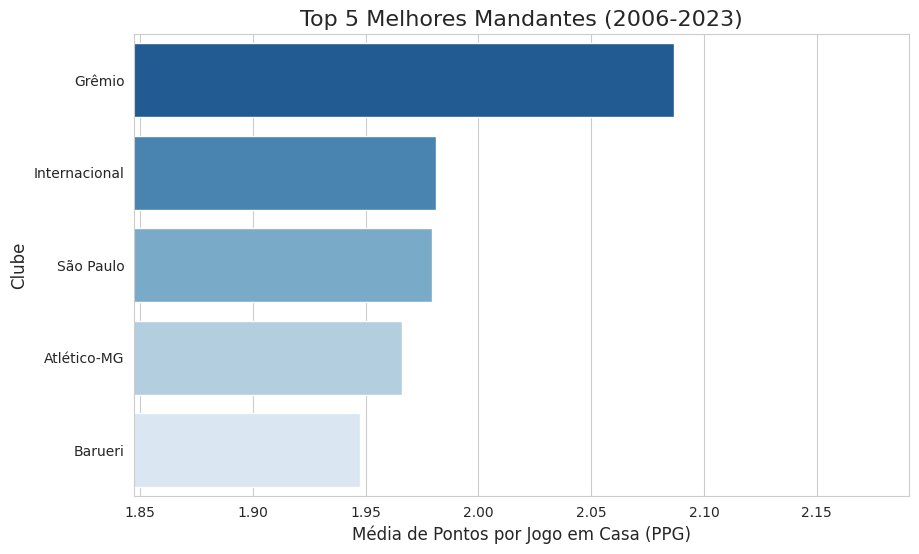

In [23]:
# Top 5 clubes com melhor desempenho em casa (mandantes).
# Agrupar por time da casa e calcular total de jogos e pontos.
home_performance = df.groupby('home_team').agg(
    total_home_games=('home_team', 'size'),
    total_home_points=('points_home', 'sum')
)

# Calcular a média de pontos por jogo em casa.
home_performance['ppg_home'] = home_performance['total_home_points'] / home_performance['total_home_games']

# Obter o Top 5.
top_5_mandantes = home_performance.nlargest(5, 'ppg_home')

# Plotar.
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_mandantes['ppg_home'], y=top_5_mandantes.index, orient='h', palette='Blues_r')
plt.title('Top 5 Melhores Mandantes (2006-2023)', fontsize=16)
plt.xlabel('Média de Pontos por Jogo em Casa (PPG)', fontsize=12)
plt.ylabel('Clube', fontsize=12)
plt.xlim(left=top_5_mandantes['ppg_home'].min() - 0.1) # Ajuste de eixo
plt.show()

/tmp/ipython-input-912770195.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_visitantes['ppg_away'], y=top_5_visitantes.index, orient='h', palette='Reds_r')


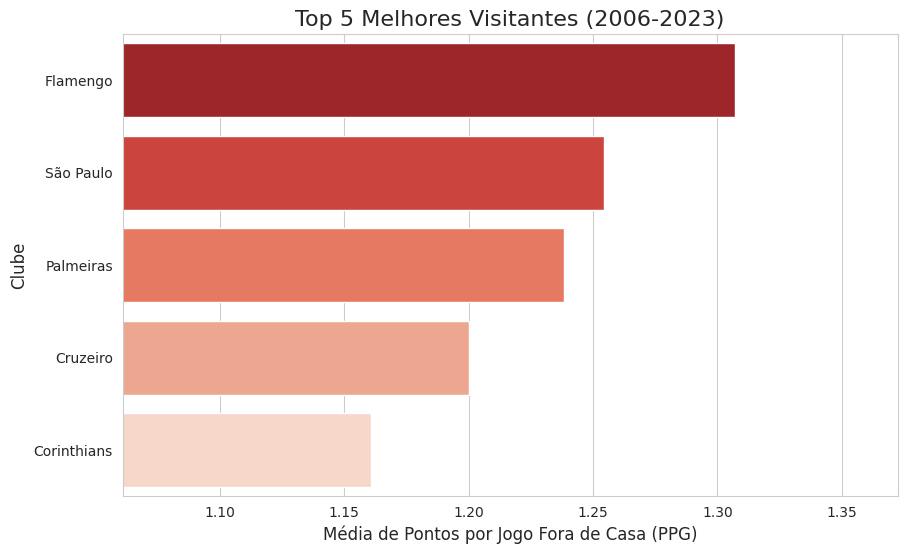

In [24]:
# Top 5 clubes com melhor desempenho fora de casa (visitantes).
# Agrupar por time visitante e calcular total de jogos e pontos.
away_performance = df.groupby('away_team').agg(
    total_away_games=('away_team', 'size'),
    total_away_points=('points_away', 'sum')
)

# Calcular a média de pontos por jogo fora de casa.
away_performance['ppg_away'] = away_performance['total_away_points'] / away_performance['total_away_games']

# Obter o Top 5
top_5_visitantes = away_performance.nlargest(5, 'ppg_away')

# Plotar.
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_visitantes['ppg_away'], y=top_5_visitantes.index, orient='h', palette='Reds_r')
plt.title('Top 5 Melhores Visitantes (2006-2023)', fontsize=16)
plt.xlabel('Média de Pontos por Jogo Fora de Casa (PPG)', fontsize=12)
plt.ylabel('Clube', fontsize=12)
plt.xlim(left=top_5_visitantes['ppg_away'].min() - 0.1) # Ajuste de eixo.
plt.show()

In [25]:
# Análise da classificação da última temporada (Temporada 2024).
# Encontrar o último ano no dataset.
last_year = df['year'].max()
print(f"--- Gerando Tabela de Classificação Final da Temporada {last_year} ---")

df_last_year = df[df['year'] == last_year].copy()

# 1. Calcular estatísticas de casa.
home_stats = df_last_year.groupby('home_team').agg(
    P_home=('points_home', 'sum'),
    W_home=('result', lambda x: (x=='H').sum()),
    D_home=('result', lambda x: (x=='D').sum()),
    L_home=('result', lambda x: (x=='A').sum()),
    GF_home=('home_score', 'sum'),
    GA_home=('away_score', 'sum')
)

# 2. Calcular estatísticas de fora.
away_stats = df_last_year.groupby('away_team').agg(
    P_away=('points_away', 'sum'),
    W_away=('result', lambda x: (x=='A').sum()),
    D_away=('result', lambda x: (x=='D').sum()),
    L_away=('result', lambda x: (x=='H').sum()),
    GF_away=('away_score', 'sum'),
    GA_away=('home_score', 'sum')
)

# 3. Concatenar e preencher times que talvez não tenham jogado em casa/fora (raro).
table = pd.concat([home_stats, away_stats], axis=1).fillna(0)

# 4. Calcular colunas finais
table['P'] = table['P_home'] + table['P_away']
table['W'] = table['W_home'] + table['W_away']
table['D'] = table['D_home'] + table['D_away']
table['L'] = table['L_home'] + table['L_away']
table['GF'] = table['GF_home'] + table['GF_away']
table['GA'] = table['GA_home'] + table['GA_away']
table['GD'] = table['GF'] - table['GA']
table['GP'] = table['W_home'] + table['D_home'] + table['L_home'] # Games Played (Jogos).

# 5. Selecionar colunas finais e ordenar.
final_table = table[['P', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'GP']].astype(int)
final_table = final_table.sort_values(by=['P', 'W', 'GD', 'GF'], ascending=[False, False, False, False])

# 6. Exibir a tabela final.
final_table.index.name = 'Clube'
display(final_table)

--- Gerando Tabela de Classificação Final da Temporada 2023 ---


,P,W,D,L,GF,GA,GD,GP
Clube,,,,,,,,
Palmeiras,70,20,10,8,64,33,31,19
Grêmio,68,21,5,12,63,56,7,19
Atlético-MG,66,19,9,10,52,32,20,19
Flamengo,66,19,9,10,56,42,14,19
Botafogo,64,18,10,10,58,37,21,19
RB Bragantino,62,17,11,10,49,35,14,19
Fluminense,56,16,8,14,51,47,4,19
Athletico-PR,56,14,14,10,51,43,8,19
Internacional,55,15,10,13,46,45,1,19



# Escolha das Features

Selecionamos features que estariam disponíveis **antes** da partida:

- `home_team` (categórica)
- `away_team` (categórica)
- `round` (numérica)
- `year` (numérica)

**Justificativa:** As colunas de placar (`home_score`, `away_score`, `soma`) são consequência do jogo e não podem ser usadas como features (vazamento de dados). `stadium` foi omitido por forte correlação com `home_team` e para simplificar o modelo.

In [26]:

# Codificar nomes dos times com LabelEncoder (fácil e reprodutível).
features = ['home_team','away_team','round','year']
X = df[features].copy()
y = df['result'].copy()

# Fit de LabelEncoder considerando todos os times.
le = LabelEncoder()
all_teams = pd.concat([X['home_team'], X['away_team']]).unique()
le.fit(all_teams)

X['home_team_enc'] = le.transform(X['home_team'])
X['away_team_enc'] = le.transform(X['away_team'])

X_model = X[['home_team_enc','away_team_enc','round','year']].copy()
display(X_model.head())

,home_team_enc,away_team_enc,round,year
1566,27,30,1,2006
1567,41,24,1,2006
1568,22,12,1,2006
1569,40,18,1,2006
1570,39,15,1,2006


## Separação dos Dados em Treino e Teste

In [27]:

# Divisão treino/teste estratificada pela label para manter proporções.
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.3, random_state=42, stratify=y
)
print('Tamanhos -> Treino:', X_train.shape, 'Teste:', X_test.shape)

Tamanhos -> Treino: (4788, 4) Teste: (2052, 4)



# Modelagem

Aplicaremos **K-Nearest Neighbors (KNN)** e **Decision Tree**. Para KNN usaremos *StandardScaler* dentro de um pipeline (sensível à escala). Para Decision Tree não há necessidade de escala, mas faremos busca em `max_depth`.

Usaremos `GridSearchCV` com validação cruzada (StratifiedKFold) para encontrar os melhores hiperparâmetros.


In [28]:
# Lista para armazenar os resultados comparativos.
results = []

## K-Nearest Neighbors (KNN)

In [29]:
# Configurar validação cruzada.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN pipeline (scaler + KNN).
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_knn = {
    'knn__n_neighbors': [5, 9, 11, 15, 21],
    'knn__weights': ['uniform', 'distance']
}

gs_knn = GridSearchCV(pipe_knn, param_knn, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
gs_knn.fit(X_train, y_train)
print('Melhor KNN:', gs_knn.best_params_, '-> CV best score:', gs_knn.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor KNN: {'knn__n_neighbors': 21, 'knn__weights': 'distance'} -> CV best score: 0.45572389360453575


### Avaliação do Modelo KNN

In [30]:
# Define o nome e o modelo.
name_knn = 'KNN'
model_knn = gs_knn.best_estimator_

# Faz as previsões.
y_pred_knn = model_knn.predict(X_test)

# Calcula as métricas.
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='macro', zero_division=0)
rec_knn = recall_score(y_test, y_pred_knn, average='macro', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='macro', zero_division=0)

# Salva os resultados na lista.
results.append({
    'Modelo': name_knn,
    'Acuracia': acc_knn,
    'Precisao_macro': prec_knn,
    'Recall_macro': rec_knn,
    'F1_macro': f1_knn
})

# Imprime os relatórios.
print(f'=== {name_knn} ===')
print('Acurácia:', f'{acc_knn*100:.2f}%')
print(classification_report(y_test, y_pred_knn, zero_division=0))

=== KNN ===
Acurácia: 44.69%
              precision    recall  f1-score   support

           A       0.23      0.08      0.12       493
           D       0.26      0.10      0.14       551
           H       0.49      0.82      0.61      1008

    accuracy                           0.45      2052
   macro avg       0.33      0.33      0.29      2052
weighted avg       0.37      0.45      0.37      2052



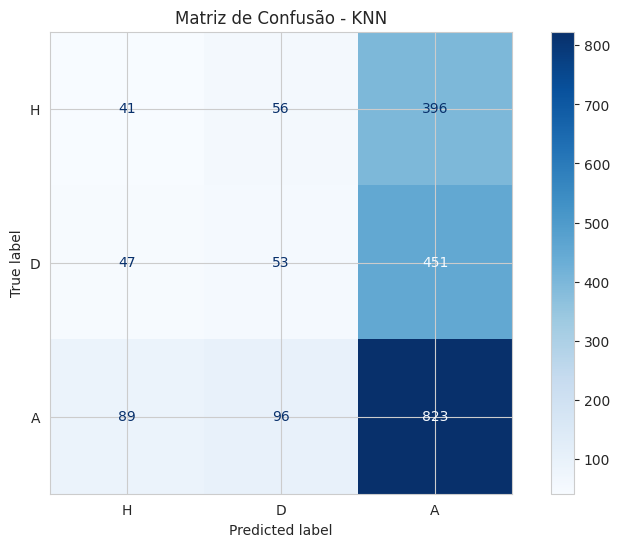

In [31]:
# Plota a Matriz de Confusão.
disp_knn = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn), display_labels=['H','D','A'])
disp_knn.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - {name_knn}')
plt.show()

## Decision Tree

In [32]:
pipe_tree = Pipeline([('tree', DecisionTreeClassifier(random_state=42))])
param_tree = {
    'tree__max_depth': [3,5,7,10,None],
    'tree__criterion': ['gini','entropy']
}

gs_tree = GridSearchCV(pipe_tree, param_tree, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
gs_tree.fit(X_train, y_train)
print('Melhor Tree:', gs_tree.best_params_, '-> CV best score:', gs_tree.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor Tree: {'tree__criterion': 'entropy', 'tree__max_depth': 3} -> CV best score: 0.4866307593972989


### Avaliação do Modelo DecisionTree

In [33]:
# Define o nome e o modelo.
name_tree = 'DecisionTree'
model_tree = gs_tree.best_estimator_

# Faz as previsões.
y_pred_tree = model_tree.predict(X_test)

# Calcula as métricas.
acc_tree = accuracy_score(y_test, y_pred_tree)
prec_tree = precision_score(y_test, y_pred_tree, average='macro', zero_division=0)
rec_tree = recall_score(y_test, y_pred_tree, average='macro', zero_division=0)
f1_tree = f1_score(y_test, y_pred_tree, average='macro', zero_division=0)

# Salva os resultados na lista.
results.append({
    'Modelo': name_tree,
    'Acuracia': acc_tree,
    'Precisao_macro': prec_tree,
    'Recall_macro': rec_tree,
    'F1_macro': f1_tree
})

# Imprime os relatórios.
print(f'=== {name_tree} ===')
print('Acurácia:', f'{acc_tree*100:.2f}%')
print(classification_report(y_test, y_pred_tree, zero_division=0))

=== DecisionTree ===
Acurácia: 49.12%
              precision    recall  f1-score   support

           A       0.35      0.01      0.02       493
           D       0.33      0.00      0.01       551
           H       0.49      0.99      0.66      1008

    accuracy                           0.49      2052
   macro avg       0.39      0.34      0.23      2052
weighted avg       0.42      0.49      0.33      2052



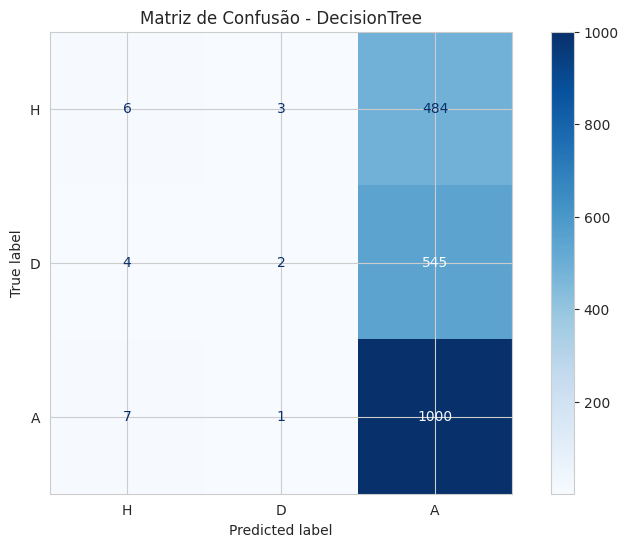

In [34]:
# Plota a Matriz de Confusão.
disp_tree = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tree), display_labels=['H','D','A'])
disp_tree.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - {name_tree}')
plt.show()

# Comparação Final

In [35]:
# Agora que 'results' contém os dados do KNN e da Decision Tree, criamos o DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Modelo,Acuracia,Precisao_macro,Recall_macro,F1_macro
0,KNN,0.446881,0.327663,0.331940,0.292412
1,DecisionTree,0.491228,0.393043,0.335955,0.229752


In [36]:
# Linha de base: sempre prever a classe majoritária.
major_class = y_train.value_counts().idxmax()
y_pred_base = [major_class] * len(y_test)
base_acc = accuracy_score(y_test, y_pred_base)
print('Classe majoritária (baseline):', major_class)
print(f'Baseline Acurácia: {base_acc*100:.2f}%')

# Crie a nova linha como um DataFrame separado
baseline_row = pd.DataFrame([{
    'Modelo': 'Baseline',
    'Acuracia': base_acc,
    'Precisao_macro': np.nan,
    'Recall_macro': np.nan,
    'F1_macro': np.nan
}])

# Use pd.concat para unir o DataFrame original com a nova linha.
results_df = pd.concat([results_df, baseline_row], ignore_index=True)

display(results_df)

Classe majoritária (baseline): H
Baseline Acurácia: 49.12%


,Modelo,Acuracia,Precisao_macro,Recall_macro,F1_macro
0,KNN,0.446881,0.327663,0.331940,0.292412
1,DecisionTree,0.491228,0.393043,0.335955,0.229752
2,Baseline,0.491228,NaN,NaN,NaN


# Conclusão
Ao final deste projeto, foram desenvolvidos e avaliados três modelos para a classificação de resultados do Campeonato Brasileiro: um modelo baseline, um K-Nearest Neighbors (KNN) e uma Árvore de Decisão (DecisionTree).

A análise comparativa revelou resultados muito claros:

O modelo Baseline, que simplesmente prevê a classe majoritária ('H' - Vitória da Casa), atingiu uma acurácia de 49.12%.

O modelo KNN otimizado (n_neighbors=21, weights='distance') obteve uma acurácia de 44.69%, performando pior que o baseline.

O modelo DecisionTree otimizado (max_depth=3) atingiu uma acurácia de 49.12%, um resultado idêntico ao baseline.

Esta descoberta é a principal conclusão do trabalho: os modelos, com as features fornecidas, não foram capazes de aprender padrões preditivos e apenas replicaram a estratégia do baseline (prever a classe mais comum). A matriz de confusão da Árvore de Decisão, por exemplo, provavelmente mostraria uma previsão massiva na classe 'H'.

A principal limitação identificada foi a simplicidade das features escolhidas. Embora a seleção (home_team_enc, away_team_enc, round, year) tenha sido correta para evitar o vazamento de dados, ela é insuficiente. Os modelos não têm informação sobre a "forma" recente da equipe (últimos resultados), força do elenco, média de gols ou histórico de confrontos, tratando "Palmeiras 2023" da mesma forma que "Palmeiras 2010".

Para trabalhos futuros, a etapa de engenharia de features é crucial. Recomenda-se a criação de atributos como:

Média de gols marcados/sofridos nos últimos 5 jogos (janela deslizante).

Pontuação acumulada no campeonato até aquela rodada.

Histórico de confronto direto entre as duas equipes.

Em suma, embora os modelos não tenham alcançado poder preditivo, o projeto demonstrou com sucesso a importância de estabelecer um baseline e provou o impacto crítico da engenharia de features no sucesso de um projeto de machine learning.